<a href="https://colab.research.google.com/github/pr401n/riverine-supervised/blob/main/lab1_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# STEP 2: Load CSV from Google Drive
from google.colab import drive
drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/data/global_riverine_plastic_emissions_into_ocean.csv'
df = pd.read_csv(csv_path)
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Country or Administrative area Area [km2] Coast length [km]  \
0                        Albania     28'486               362   
1                        Algeria  2'316'559               998   
2                         Angola  1'247'357             1'600   
3            Antigua and Barbuda        443               153   
4                      Argentina  2'779'705             4'989   

  Rainfall [mm year -1]  Factor L/A [-]  Factor (L/A) *P [-] P[E] [%]  \
0                 1'117          0.0100                 14.0    1.56%   
1                    80          0.0004                  0.0    0.09%   
2                 1'025          0.0010                  1.0    0.09%   
3                   996          0.3000                344.0    3.08%   
4                   567          0.0020                  1.0    0.26%   

  MPW (metric tons year -1) M[E] (metric 

In [25]:
def clean_data_auto(df):
    """Automated column cleaning without manual naming."""

    # 1. Auto-detect numeric columns needing apostrophe removal
    num_pattern = r"\d+'\d+"
    str_num_cols = [col for col in df.columns
                   if df[col].astype(str).str.contains(num_pattern).any()]

    for col in str_num_cols:
        df[col] = df[col].astype(str).str.replace("'", "").astype(float)

    # 2. Auto-detect percentage columns
    pct_cols = [col for col in df.columns if '%' in col or '[%]' in col]
    for col in pct_cols:
        df[col] = df[col].astype(str).str.replace('%', '').astype(float) / 100

    # 3. Auto-select critical columns containing key terms
    critical_keywords = ['M[E]', 'Coast', 'Rainfall']
    critical_cols = [col for col in df.columns
                    if any(kwd in col for kwd in critical_keywords)]

    return df.dropna(subset=critical_cols)

data_clean = clean_data_auto(df)

In [27]:
# Remove columns where ALL values are NaN
data_clean = data_clean.dropna(axis=1, how='all')
print(data_clean.head())

  Country or Administrative area  Area [km2]  Coast length [km]  \
0                        Albania     28486.0              362.0   
1                        Algeria   2316559.0              998.0   
2                         Angola   1247357.0             1600.0   
3            Antigua and Barbuda       443.0              153.0   
4                      Argentina   2779705.0             4989.0   

   Rainfall [mm year -1]  Factor L/A [-]  Factor (L/A) *P [-]  P[E] [%]  \
0                 1117.0          0.0100                 14.0    0.0156   
1                   80.0          0.0004                  0.0    0.0009   
2                 1025.0          0.0010                  1.0    0.0009   
3                  996.0          0.3000                344.0    0.0308   
4                  567.0          0.0020                  1.0    0.0026   

   MPW (metric tons year -1)  M[E] (metric tons year -1) Ratio Me/MPW  
0                    69833.0                      1565.0        2.24%  
1 

In [28]:
THRESHOLD = 6008

# Create the new column using a conditional
data_clean['plastic_contribution'] = (data_clean['M[E] (metric tons year -1)'] <= THRESHOLD).astype(int)
print(data_clean.head())

  Country or Administrative area  Area [km2]  Coast length [km]  \
0                        Albania     28486.0              362.0   
1                        Algeria   2316559.0              998.0   
2                         Angola   1247357.0             1600.0   
3            Antigua and Barbuda       443.0              153.0   
4                      Argentina   2779705.0             4989.0   

   Rainfall [mm year -1]  Factor L/A [-]  Factor (L/A) *P [-]  P[E] [%]  \
0                 1117.0          0.0100                 14.0    0.0156   
1                   80.0          0.0004                  0.0    0.0009   
2                 1025.0          0.0010                  1.0    0.0009   
3                  996.0          0.3000                344.0    0.0308   
4                  567.0          0.0020                  1.0    0.0026   

   MPW (metric tons year -1)  M[E] (metric tons year -1) Ratio Me/MPW  \
0                    69833.0                      1565.0        2.24%   


In [31]:
# Select numeric features to scale (excluding target and identifiers)
numeric_cols = data_clean.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col not in
               ['plastic_contribution', 'M[E] (metric tons year -1)']]

# Initialize RobustScaler (resistant to outliers)
scaler = RobustScaler()

# Scale features and keep column names
data_scaled = data_clean.copy()
data_scaled[numeric_cols] = scaler.fit_transform(data_clean[numeric_cols])

# Verify scaling
print(data_scaled[numeric_cols].describe().round(2))

       Area [km2]  Coast length [km]  Rainfall [mm year -1]  Factor L/A [-]  \
count      163.00             163.00                 163.00          163.00   
mean         1.40               1.70                   0.12            2.34   
std          4.66               7.95                   0.70            7.55   
min         -0.25              -0.30                  -0.89           -0.13   
25%         -0.22              -0.17                  -0.41           -0.10   
50%          0.00               0.00                   0.00            0.00   
75%          0.78               0.83                   0.59            0.90   
max         38.14              93.32                   2.28           58.69   

       Factor (L/A) *P [-]  P[E] [%]  MPW (metric tons year -1)  
count               163.00    163.00                     163.00  
mean                  2.64      0.52                       1.67  
std                  10.38      1.07                       6.87  
min                  -0.

In [32]:
# 3. Select features and target
features = ['Area [km2]', 'Coast length [km]', 'Rainfall [mm year -1]',
            'MPW (metric tons year -1)', 'P[E] [%]', 'Factor (L/A) *P [-]']
X = data_clean[features]
y = data_clean['plastic_contribution']

In [33]:
# 4. Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [34]:
# 5. Scale features (RobustScaler for outlier resistance)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:

# 6. Initialize and train Random Forest
model = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_depth=10,            # Prevent overfitting
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [37]:
# 7. Evaluate
y_pred = model.predict(X_test_scaled)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [38]:

print("=== Performance Metrics ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Performance Metrics ===
Accuracy: 0.91
Precision: 0.91
Recall: 1.00

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.91      1.00      0.95        30

    accuracy                           0.91        33
   macro avg       0.45      0.50      0.48        33
weighted avg       0.83      0.91      0.87        33



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


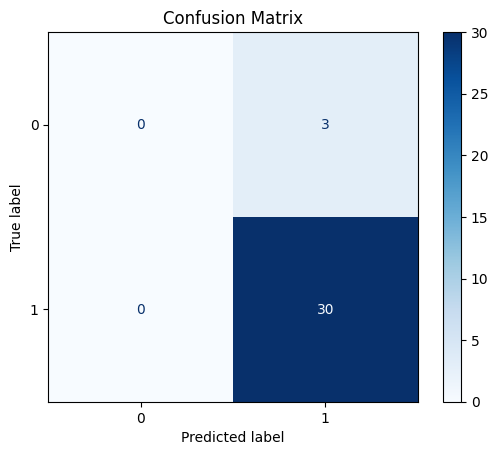

In [42]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

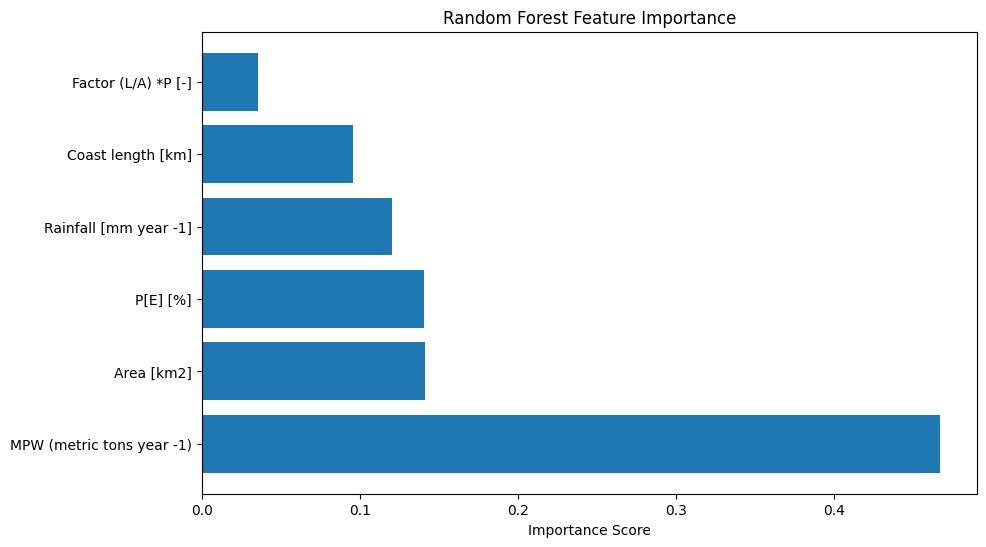

In [40]:
# 8. Feature Importance
importances = model.feature_importances_
feature_imp = pd.DataFrame({'Feature': features, 'Importance': importances})\
               .sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp['Feature'], feature_imp['Importance'])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.show()

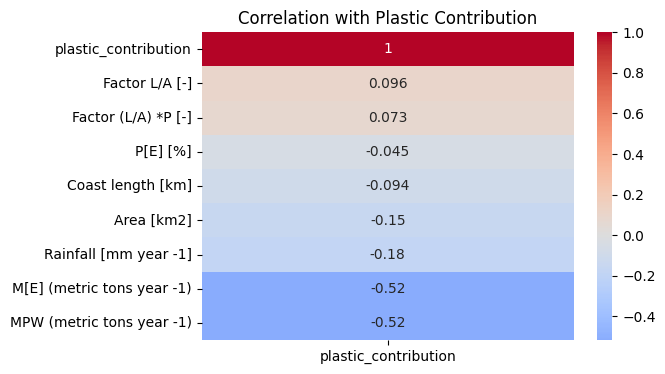

In [44]:
# Calculate correlations with target
correlations = data_clean.corr(numeric_only=True)[['plastic_contribution']]\
                 .sort_values('plastic_contribution', ascending=False)

# Visualize
plt.figure(figsize=(6, 4))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with Plastic Contribution")
plt.show()